In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from time import time
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score as f1_score_rep
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

2024-01-30 10:07:55.705754: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 10:07:55.854678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 10:07:55.854771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 10:07:55.857678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 10:07:55.876489: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 10:07:55.877341: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
x_test = np.load('/home/jovyan/UNSW/x_test.npy',allow_pickle=True)
x_train = np.load('/home/jovyan/UNSW/x_train.npy',allow_pickle=True)
x_val = np.load('/home/jovyan/UNSW/x_val.npy',allow_pickle=True)
y_test = np.load('/home/jovyan/UNSW/y_test.npy',allow_pickle=True)
y_train = np.load('/home/jovyan/UNSW/y_train.npy',allow_pickle=True)
y_val = np.load('/home/jovyan/UNSW/y_val.npy',allow_pickle=True)

In [3]:
timesteps = 1 # Number of timesteps; adjust based on your data
features_per_timestep = x_train.shape[1] # Features per timestep
x_train = x_train.reshape(-1, timesteps, features_per_timestep)
x_val = x_val.reshape(-1, timesteps, features_per_timestep)
x_test = x_test.reshape(-1, timesteps, features_per_timestep)

input_shape = x_train.shape[1:]
num_classes = len(np.unique(y_train))


rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
rnn_model.add(SimpleRNN(50))
rnn_model.add(Dense(units=30, activation='relu'))
rnn_model.add(Dense(units=num_classes, activation='softmax'))



opt = SGD(lr=0.01)

rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
hist = rnn_model.fit(x_train, y_train, epochs=10, batch_size=64,
                     validation_data=(x_val, y_val), # validation
                     callbacks=[early_stopping])

test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

y_hat = rnn_model.predict(x_test)
y_hat = np.argmax(y_hat, axis=-1)

2024-01-30 10:08:00.485568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
1287/1287 [==============================] - 10s 6ms/step - loss: 0.3348 - accuracy: 0.8371 - val_loss: 0.2379 - val_accuracy: 0.8932
Epoch 2/10
1287/1287 [==============================] - 6s 5ms/step - loss: 0.2056 - accuracy: 0.9092 - val_loss: 0.1918 - val_accuracy: 0.9134
Epoch 3/10
1287/1287 [==============================] - 7s 5ms/step - loss: 0.1721 - accuracy: 0.9272 - val_loss: 0.1643 - val_accuracy: 0.9336
Epoch 4/10
1287/1287 [==============================] - 6s 5ms/step - loss: 0.1549 - accuracy: 0.9376 - val_loss: 0.1463 - val_accuracy: 0.9458
Epoch 5/10
1287/1287 [==============================] - 6s 5ms/step - loss: 0.1446 - accuracy: 0.9429 - val_loss: 0.1483 - val_accuracy: 0.9371
Epoch 6/10
1287/1287 [==============================] - 7s 5ms/step - loss: 0.1376 - accuracy: 0.9467 - val_loss: 0.1321 - val_accuracy: 0.9513
Epoch 7/10
1287/1287 [==============================] - 7s 5ms/step - loss: 0.1324 - accuracy: 0.9482 - val_loss: 0.1645 - val_accuracy

FPR: [0.14635624 0.03101648]
TPR: [0.96898352 0.85364376]
FNR: [0.03101648 0.14635624]
TNR: [0.85364376 0.96898352]
Precision: 0.8698674373739224
Accuracy: 0.8904809118108993
F1-score: 0.8817632313932409
FPR: 0.08868636244767467
tpr: 0.9113136375523253
fnr: 0.08868636244767467
tnr: 0.9113136375523253


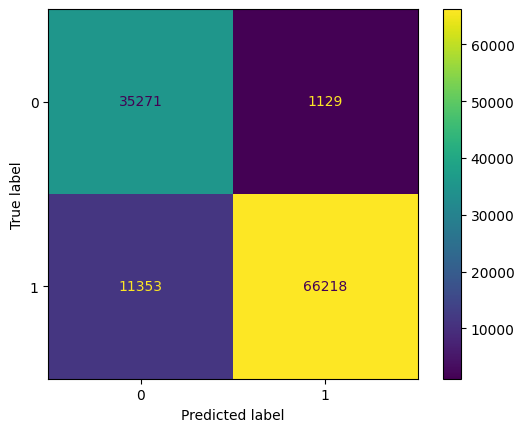

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, roc_auc_score



conf_matrix = confusion_matrix(y_test, y_hat)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_hat, average='macro')
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='macro')
# auc = roc_auc_score(y_test, rnn_model.predict(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
# print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "rnn",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    # "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a', index=False)